In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from scipy.ndimage import gaussian_filter
import copy
# from sklearn.neighbors import KernelDensity
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import colorcet as cc
import warnings
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re
%matplotlib inline

In [2]:
PHASE = 'Winter'

varname = 'wspd10m'
# varname = 'q2sd'

if PHASE == 'Summer':
    lon_bounds = [-180, 180]
    lat_bounds = [-15, 30]
if PHASE == 'Winter':
    lon_bounds = [-180, 180]
    lat_bounds = [-30, 15]

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/{PHASE}/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'm1': 'SCREAM',
        'm2': 'SCREAMv1',
    }

if PHASE == 'Winter':
    name_map = {
        # 'obs': 'OBS',
        'm1': 'SCREAM',
        'm2': 'SCREAMv1',
    }

# Environmental files
envfiles_map = {key:f'{rootdir}{value}/envs/{PHASE}_{value}_{varname}_map.nc' for key,value in name_map.items()}

topfile = '/global/cfs/cdirs/m1867/zfeng/gpm/map_data/era5_orography.nc'

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/PyFLEXTRKR/SCREAM/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/PyFLEXTRKR/SCREAM/


## Check if input files exist

In [3]:
for key, value in envfiles_map.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/Winter/SCREAM/envs/Winter_SCREAM_wspd10m_map.nc: True
/pscratch/sd/f/feng045/DYAMOND/Winter/SCREAMv1/envs/Winter_SCREAMv1_wspd10m_map.nc: True


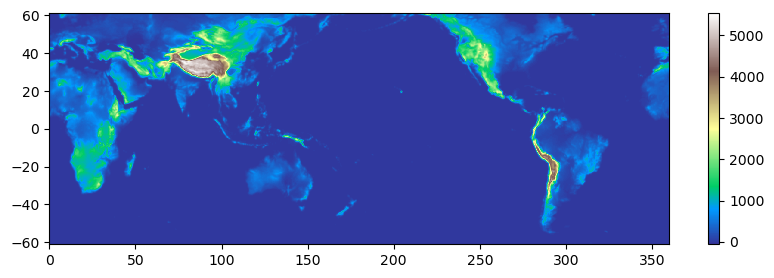

In [4]:
# Read topography data
dstop = xr.open_dataset(topfile)
# Convert surface geopotential to height in meters
ter = dstop.z.sel(latitude=slice(61,-61)).squeeze() / 9.80665
ter_s = gaussian_filter(ter, 1)
lon_ter = dstop.longitude
lat_ter = dstop.latitude.sel(latitude=slice(61,-61))

fig = plt.figure(figsize=[10,3], dpi=100)
plt.pcolormesh(lon_ter, lat_ter, ter_s, cmap='terrain')
plt.colorbar()

In [5]:
# Read all model data in Xarray Dataset
dsm = xr.open_mfdataset(list(envfiles_map.values())[:], concat_dim='source', combine='nested')
# Assign new coordinate 'source' using names
dsm['source'] = list(name_map.keys())[:]
lon = dsm.lon
lat = dsm.lat
start_date = dsm.attrs['start_date']
end_date = dsm.attrs['end_date']
dsm

<xarray.Dataset>
Dimensions:           (source: 2, lat: 479, lon: 1440)
Coordinates:
  * lat               (lat) float64 -59.75 -59.5 -59.25 ... 59.25 59.5 59.75
  * lon               (lon) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * source            (source) <U2 'm1' 'm2'
Data variables:
    landseamask       (source, lat, lon) float32 dask.array<chunksize=(1, 479, 1440), meta=np.ndarray>
    wspd10m           (source, lat, lon) float32 dask.array<chunksize=(1, 479, 1440), meta=np.ndarray>
    wspd10m_ccs       (source, lat, lon) float32 dask.array<chunksize=(1, 479, 1440), meta=np.ndarray>
    wspd10m_mcs       (source, lat, lon) float32 dask.array<chunksize=(1, 479, 1440), meta=np.ndarray>
    wspd10m_ccs_cond  (source, lat, lon) float32 dask.array<chunksize=(1, 479, 1440), meta=np.ndarray>
    wspd10m_mcs_cond  (source, lat, lon) float32 dask.array<chunksize=(1, 479, 1440), meta=np.ndarray>
    ccs_freq          (source, lat, lon) float32 dask.array<chunksize=(1, 479, 1440), meta=np.ndarray>
    mcs_freq          (source, lat, lon) float32 dask.array<chunksize=(1, 479, 1440), meta=np.ndarray>
    ntimes            (source) float32 672.0 672.0
Attributes:
    title:       Time sum wspd10m map
    ntimes:      672
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    created_on:  Thu Sep  5 10:40:28 2024

In [6]:
# lhx_m1 = dsm.lhx.sel(source='m1') / dsm.ntimes.sel(source='m1')
# plt.pcolormesh(lon, lat, lhx_m1)
# plt.colorbar()

In [7]:
# lhx_m1 = dsm.lhx.sel(source='m1') / dsm.ntimes.sel(source='m1')
# lhx_m2 = dsm.lhx.sel(source='m2') / dsm.ntimes.sel(source='m2')
# diff = lhx_m2 - lhx_m1
# plt.pcolormesh(lon, lat, diff, vmin=-100, vmax=100, cmap='RdBu_r')
# plt.colorbar()

In [8]:
def get_diff(ds, varname, source1, source2):
    """
    Get DataArray differences
    
    Args:
        da: DataArray
            DataArray containing multiple sources (including 'obs' & models)
            
    Returns:
        da_mod: DataArray
            DataArray containing models
        da_diff: DataArray
            DataArray containing differences    
    """
    # Select variable for specified sources
    # da1 = ds[varname].sel(source=source1).squeeze() / ds['ntimes'].sel(source=source1)
    # da2 = ds[varname].sel(source=source2).squeeze() / ds['ntimes'].sel(source=source2)
    da1 = ds[varname].sel(source=source1).squeeze()
    da2 = ds[varname].sel(source=source2).squeeze()
    # Compute the difference (model - obs)
    da_diff = da2 - da1
    return (da1, da2, da_diff)

In [9]:
VAR_m1, VAR_m2, VAR_diff = get_diff(dsm, varname, 'm1', 'm2')
VAR_ccs_m1, VAR_ccs_m2, VAR_ccs_diff = get_diff(dsm, f'{varname}_ccs', 'm1', 'm2')
VAR_mcs_m1, VAR_mcs_m2, VAR_mcs_diff = get_diff(dsm, f'{varname}_mcs', 'm1', 'm2')
# Conditional mean
VAR_ccs_cond_m1, VAR_ccs_cond_m2, VAR_ccs_cond_diff = get_diff(dsm, f'{varname}_ccs_cond', 'm1', 'm2')
VAR_mcs_cond_m1, VAR_mcs_cond_m2, VAR_mcs_cond_diff = get_diff(dsm, f'{varname}_mcs_cond', 'm1', 'm2')

# Get CCS/MCS frequency
ccs_freq_m1 = dsm['ccs_freq'].sel(source='m1').squeeze()
ccs_freq_m2 = dsm['ccs_freq'].sel(source='m2').squeeze()
mcs_freq_m1 = dsm['mcs_freq'].sel(source='m1').squeeze()
mcs_freq_m2 = dsm['mcs_freq'].sel(source='m2').squeeze()

In [10]:
# # full_dict['cmap1'].N
# norm = colors.BoundaryNorm(boundaries=full_dict['lev1'], ncolors=full_dict['cmap1'].N)
# plt.pcolormesh(lon, lat, VAR_m1, norm=norm, cmap=full_dict['cmap1'])
# plt.colorbar()

In [11]:
# # VAR_m1.plot()
# plt.pcolormesh(lon, lat, VAR_diff, vmin=-5, vmax=5, cmap='PRGn')
# plt.colorbar()

In [12]:
# plt.pcolormesh(lon, lat, VAR_ccs_m1, vmin=0, vmax=6, cmap=cc.cm['rainbow4'])
# plt.colorbar()

In [13]:
# plt.pcolormesh(lon, lat, ccs_freq_m1, vmin=0, vmax=20, cmap=cc.cm['rainbow4'])
# plt.colorbar()

In [14]:
# plt.pcolormesh(lon, lat, mcs_freq_m1, vmin=0, vmax=10, cmap=cc.cm['rainbow4'])
# plt.colorbar()

In [15]:
# plt.pcolormesh(lon, lat, ccs_freq_m2, vmin=0, vmax=20, cmap=cc.cm['rainbow4'])
# plt.colorbar()

In [16]:
# min_freq = 1
# Zm = VAR_ccs_cond_m1.where(ccs_freq_m1 > min_freq)
# plt.pcolormesh(lon, lat, Zm, vmin=0, vmax=25, cmap=cc.cm['rainbow4'])
# plt.colorbar()

In [17]:
# Zm = VAR_ccs_cond_diff.where((ccs_freq_m1 > min_freq) & (ccs_freq_m2 > min_freq))
# plt.pcolormesh(lon, lat, Zm, vmin=-6, vmax=6, cmap='PRGn')
# plt.colorbar()

In [18]:
# plt.pcolormesh(lon, lat, mcs_freq_m2, vmin=0, vmax=10, cmap=cc.cm['rainbow4'])
# plt.colorbar()

In [19]:
# min_freq = 1
# Zm = VAR_mcs_cond_m1.where(mcs_freq_m1 > min_freq)
# plt.pcolormesh(lon, lat, Zm, vmin=0, vmax=25, cmap=cc.cm['rainbow4'])
# plt.colorbar()

In [20]:
# min_freq = 1
# Zm = VAR_mcs_cond_m2.where(mcs_freq_m2 > min_freq)
# plt.pcolormesh(lon, lat, Zm, vmin=0, vmax=25, cmap=cc.cm['rainbow4'])
# plt.colorbar()

In [21]:
# min_freq = 1
# Zm = VAR_mcs_cond_diff.where((mcs_freq_m1 > min_freq) & (mcs_freq_m2 > min_freq))
# plt.pcolormesh(lon, lat, Zm, vmin=-6, vmax=6, cmap='PRGn')
# plt.colorbar()

# These customed functions enables use of [NCL colormaps](https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml)

In [22]:
color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # finally convert rgb colors back to hex
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))

        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python

    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])

    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    #     white_ext:     whether to add this above white as an extended color (when set to True), or just replace the first color (when set to False).
    #     reverse_cmap:  similar to "_r" in colormap.
    # note:  reverse_cmap is applied first, then white_first option.

    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)

    if reverse_cmap==True:
        cmap_discrete_raw.reverse()

    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw

    if cont_opt==False:
        out_cmap = cmap_discrete

    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])

    return mpl.colors.ListedColormap(out_cmap)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [23]:
# Min CCS, MCS frequency threshold to filter plots
min_freq_ccs = 1.0  # [%]
min_freq_mcs = 1.0  # [%]

In [24]:
# 10m wind speed
if (varname == 'wspd10m'):
    cb_text = 'Wind Speed (m s$^{-1}$)'
    full_dict = {
        'lev1': np.arange(0, 14.1, 1),
        'lev2': np.arange(-5, 5.1, 1),
        # 'cmap1': cc.cm['CET_L17'],
        'cmap1': generate_NCL_cmap('wind_17lev'),
        'cmap2': copy.copy(mpl.colormaps.get_cmap('PRGn')),
        'title': '10m Wind',
    }
    ccs_dict = {
        'lev1': np.arange(0, 24, 2),
        'lev2': np.arange(-6, 6.1, 1),
        # 'cmap1': cc.cm['CET_L17'],
        'cmap1': generate_NCL_cmap('wind_17lev'),
        'cmap2': copy.copy(mpl.colormaps.get_cmap('PRGn')),
        'title': 'CCS 10m Wind',
    }
    mcs_dict = {
        'lev1': np.arange(0, 24, 2),
        'lev2': np.arange(-6, 6.1, 1),
        # 'cmap1': cc.cm['CET_L17'],
        'cmap1': generate_NCL_cmap('wind_17lev'),
        'cmap2': copy.copy(mpl.colormaps.get_cmap('PRGn')),
        'title': 'MCS 10m Wind',
    }

In [25]:
# Saturation deficit
if (varname == 'q2sd'):
    cb_text = 'Sat. Def. (g kg$^{-1}$)'
    full_dict = {
        'lev1': np.arange(0, 30.1, 2),
        'lev2': np.arange(-8, 8.1, 1),
        'cmap1': cc.cm['CET_L17'],
        'cmap2': copy.copy(mpl.colormaps.get_cmap('BrBG_r')),
        'title': 'Saturation Deficit',
    }
    ccs_dict = {
        'lev1': np.arange(0, 20.1, 2),
        'lev2': np.arange(-6, 6.1, 1),
        'cmap1': cc.cm['CET_L17'],
        'cmap2': copy.copy(mpl.colormaps.get_cmap('BrBG_r')),
        'title': 'CCS Saturation Deficit',
    }
    mcs_dict = {
        'lev1': np.arange(0, 20.1, 2),
        'lev2': np.arange(-6, 6.1, 1),
        'cmap1': cc.cm['CET_L17'],
        'cmap2': copy.copy(mpl.colormaps.get_cmap('BrBG_r')),
        'title': 'MCS Saturation Deficit',
    }

## Plotting function

In [26]:
def plot_maps_mxn(nrow, ncol, da, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                  oob_colors=None, contourf=False, figsize=None, fontsize=None, cb_fontsize=None, show_cb2=False, figtitle=None,
                  map_extent=None, lonv=None, latv=None, label_lon=None, label_lat=None,
                  boxes=None, boxtextloc=None, boxtext=None, boxtexttype=None, text_colors=None):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    proj = ccrs.PlateCarree(central_longitude=0)
    data_proj = ccrs.PlateCarree()
    resolution = '50m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    # states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=figsize, dpi=100)
    # Set up panels (nrow x ncol)
    h_ratios = list(np.repeat(1,nrow))
    w_ratios = list(np.repeat(1,ncol))
    wspace = None
    hspace = None
    gs = gridspec.GridSpec(nrow, ncol, figure=fig, height_ratios=h_ratios, width_ratios=w_ratios, wspace=wspace, hspace=hspace)
    
    # Loop over rows and columns
    for row in range(nrow):
        for col in range(ncol):
            # Check if variable is None
            Var = da[row][col]
            if (Var is not None):
                # Setup two columns (left: plot, right: colorbar)
                gss = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[row,col], height_ratios=[1], width_ratios=[1,0.02], wspace=0.02, hspace=0.)
                ax = plt.subplot(gss[0], projection=proj)
                ax.set_extent(map_extent, crs=proj)
                ax.add_feature(land, facecolor='none', edgecolor='k', zorder=2)
                # ax.add_feature(states, facecolor='none', edgecolor='k', zorder=2)
                ax.set_aspect('auto', adjustable=None)
                ax.set_title(titles[row][col], loc='left')
                # Grid lines & labels
                gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
                gl.top_labels = False
                gl.right_labels = False
                gl.xlocator = mpl.ticker.FixedLocator(lonv)
                gl.ylocator = mpl.ticker.FixedLocator(latv)
                lon_formatter = LongitudeFormatter(zero_direction_label=True)
                lat_formatter = LatitudeFormatter()
                if (label_lon is not None):
                    if (label_lon[row][col]):
                        ax.set_xticks(lonv, crs=data_proj)
                        ax.xaxis.set_major_formatter(lon_formatter)
                if (label_lat is not None):
                    if (label_lat[row][col]):
                        ax.set_yticks(latv, crs=data_proj)
                        ax.yaxis.set_major_formatter(lat_formatter)

                # Terrain height
                ct = ax.contour(lon_ter, lat_ter, ter_s, levels=levelshgt, \
                                colors='dimgray', linewidths=1, transform=data_proj, zorder=2)

                # Select and mask data source
                Zm = np.ma.masked_where(np.isnan(Var), Var)
                lev = levels[row][col]
                cmap = copy.copy(mpl.colormaps.get_cmap(cmaps[row][col]))
                # Set out-of-bounds colors
                if oob_colors is not None:
                    oob_c = oob_colors[row][col]
                    if oob_c is not None:
                        cmap.set_over(oob_c['over'])
                        cmap.set_under(oob_c['under'])
                norm = colors.BoundaryNorm(boundaries=lev, ncolors=cmap.N)
                # Plot data
                if (contourf == False):
                    cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=data_proj, zorder=1)
                else:
                    cf1 = ax.contourf(lon, lat, Zm, levels=levels, norm=norm, cmap=cmap, transform=data_proj, extend='both', zorder=1)

                # Colorbar
                cax = plt.subplot(gss[1])
                cbar = plt.colorbar(cf1, cax=cax, label=cblabels[row][col], ticks=cbticks[row][col], orientation='vertical', extend='both')
                cbar.ax.tick_params(labelsize=cb_fontsize)
                
                # Plot boxes
                if boxes is not None:
                    for ii in boxes:
                        # Plot region boxes
                        corners = [[boxes[ii][0],boxes[ii][2]], [boxes[ii][1],boxes[ii][2]], [boxes[ii][1],boxes[ii][3]], [boxes[ii][0],boxes[ii][3]]]
                        box = mpl.patches.Polygon(corners, edgecolor='k', facecolor='none', lw=2, transform=data_proj, zorder=3)
                        ax.add_patch(box)

                        if boxtexttype is None:
                            text_color = text_colors['pos'] if (boxtext[ii] >=0) else text_colors['neg']
                            ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]:.00f}%", ha='center',
                                    bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                                    fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
                        else:
                            text_color = 'k'
                            ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]}", ha='center',
                                    bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                                    fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
                   
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [27]:
# Define tropical region
boxes = {'Tropics': [lon_bounds[0],lon_bounds[1],lat_bounds[0],lat_bounds[1]]}
# Make text location
text_loc_x = np.zeros(len(boxes), dtype=float)
for ii, name in enumerate(boxes):
    text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
text_loc_y = [
    boxes['Tropics'][3]+4,
]
text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))
text_val = dict(zip(boxes.keys(),boxes.keys()))

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/PyFLEXTRKR/SCREAM/globalmap_scream_wspd10m_all.png


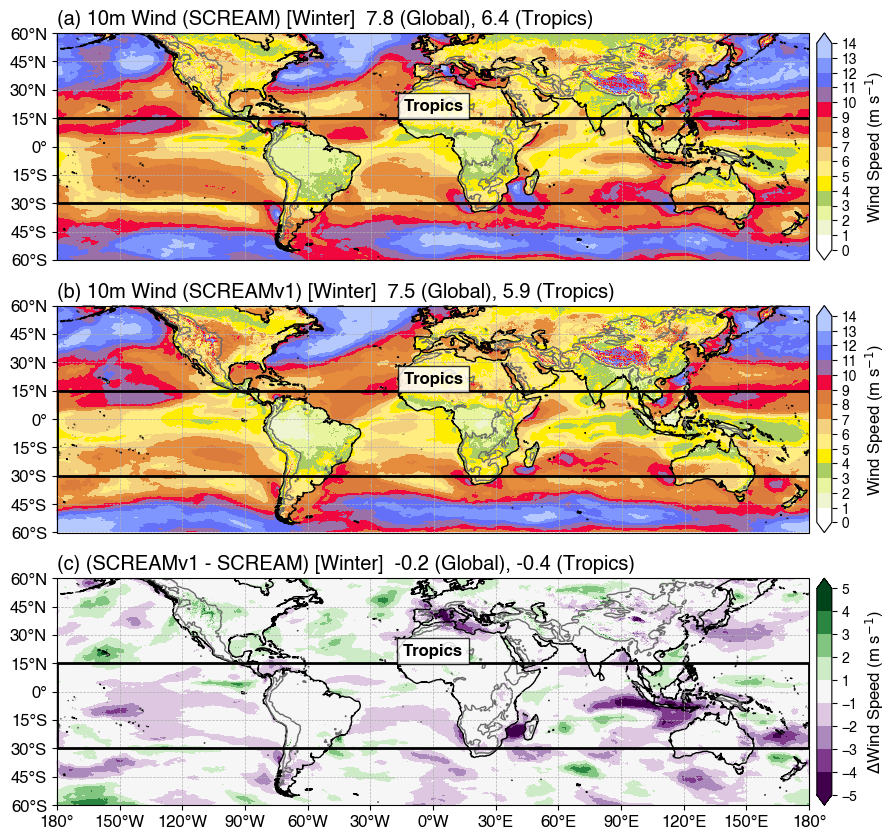

In [28]:
dataarray = [[VAR_m1], [VAR_m2], [VAR_diff]]
nrow = len(dataarray)
ncol = len(dataarray[0])
# Global mean
avg_m1 = VAR_m1.mean().values.item()
avg_m2 = VAR_m2.mean().values.item()
avg_diff = VAR_diff.mean().values.item()
# Tropics mean
avg_tropics_m1 = VAR_m1.sel(lat=slice(lat_bounds[0],lat_bounds[1]), lon=slice(lon_bounds[0],lon_bounds[1])).mean().values.item()
avg_tropics_m2 = VAR_m2.sel(lat=slice(lat_bounds[0],lat_bounds[1]), lon=slice(lon_bounds[0],lon_bounds[1])).mean().values.item()
avg_diff_tropics = VAR_diff.sel(lat=slice(lat_bounds[0],lat_bounds[1]), lon=slice(lon_bounds[0],lon_bounds[1])).mean().values.item()

map_extent = [-180., 179.5, -60.1, 60.1]
lonv = np.arange(-180,180.1,30)
latv = np.arange(-60,60.1,15)

figwidth = 10
height_ratio_per_panel = (map_extent[3] - map_extent[2]) / (map_extent[1] - map_extent[0])
figheight = nrow * (figwidth / ncol) * height_ratio_per_panel
figsize = [figwidth,figheight]

# Set up contour levels and colormaps
# lev1 = np.arange(0, 14.1, 1)
# lev2 = np.arange(-5, 5.1, 1)
lev1 = full_dict['lev1']
lev2 = full_dict['lev2']
# Remove mid-point (0 value)
idx = int((len(lev2)-1)/2)
lev2 = np.delete(lev2, idx)
levels = [[lev1]*ncol, [lev1]*ncol, [lev2]*ncol]
cmap1 = full_dict['cmap1']
cmap2 = full_dict['cmap2']
cmaps = [[cmap1]*ncol,[cmap1]*ncol,[cmap2]*ncol]
# Specify lat/lon labels
label_lon = [[False],[False],[True],]
label_lat = [[True],[True],[True]]

titles = [
    [f"(a) {full_dict['title']} ({name_map['m1']}) [{PHASE}]  {avg_m1:0.1f} (Global), {avg_tropics_m1:0.1f} (Tropics)"],
    [f"(b) {full_dict['title']} ({name_map['m2']}) [{PHASE}]  {avg_m2:0.1f} (Global), {avg_tropics_m2:0.1f} (Tropics)"],
    [f"(c) ({name_map['m2']} - {name_map['m1']}) [{PHASE}]  {avg_diff:0.1f} (Global), {avg_diff_tropics:0.1f} (Tropics)"],
]
cblabels = [[cb_text],[cb_text],[r'$\Delta$'+cb_text]]
cbticks = levels
figname = f"{figdir}globalmap_scream_{varname}_all.png"
# oob_colors = [
#     [{'under':'white', 'over':'firebrick'}]*ncol,
#     [{'under':'white', 'over':'firebrick'}]*ncol,
#     [None]*ncol,
# ]
oob_colors = None
fontsize = 12
cb_fontsize = 10
print(figname)

fig = plot_maps_mxn(nrow, ncol, dataarray, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                    figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, show_cb2=False,
                    boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
                    map_extent=map_extent, lonv=lonv, latv=latv, label_lon=label_lon, label_lat=label_lat)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/PyFLEXTRKR/SCREAM/globalmap_scream_wspd10m_ccs.png


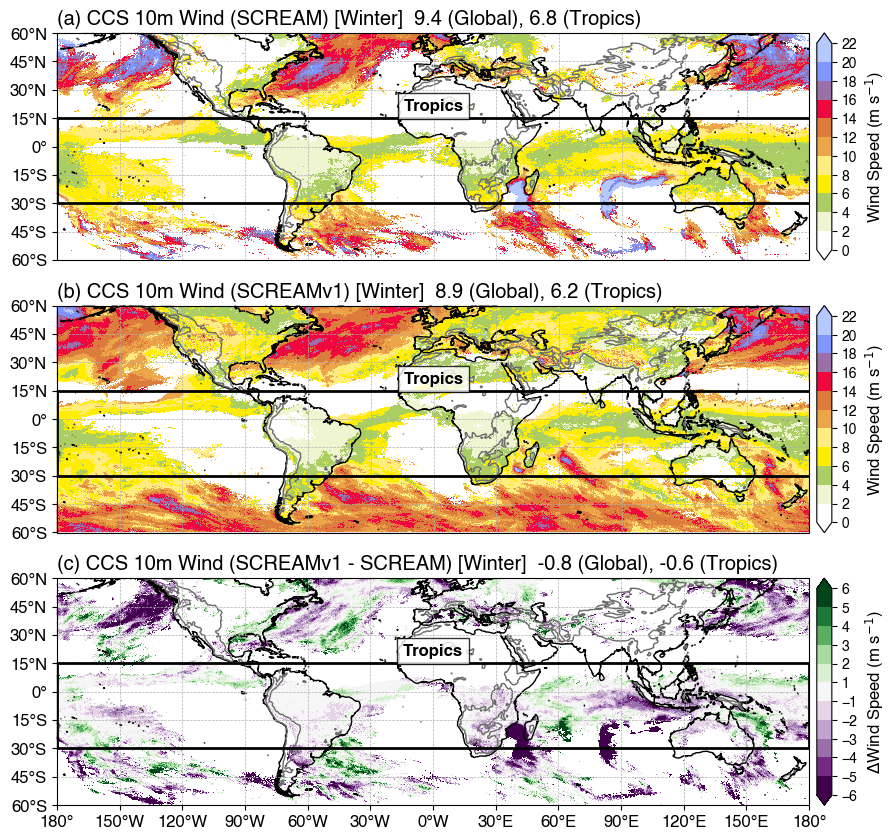

In [29]:
# Filter VAR with min frequency threshold
VAR1 = VAR_ccs_cond_m1.where(ccs_freq_m1 > min_freq_ccs)
VAR2 = VAR_ccs_cond_m2.where(ccs_freq_m2 > min_freq_ccs)
VAR3 = VAR_ccs_cond_diff.where((ccs_freq_m1 > min_freq_ccs) & (ccs_freq_m2 > min_freq_ccs))
dataarray = [[VAR1], [VAR2], [VAR3]]
nrow = len(dataarray)
ncol = len(dataarray[0])
# Global mean
avg_m1 = VAR1.mean().values.item()
avg_m2 = VAR2.mean().values.item()
avg_diff = VAR3.mean().values.item()
# Tropics mean
avg_tropics_m1 = VAR1.sel(lat=slice(lat_bounds[0],lat_bounds[1]), lon=slice(lon_bounds[0],lon_bounds[1])).mean().values.item()
avg_tropics_m2 = VAR2.sel(lat=slice(lat_bounds[0],lat_bounds[1]), lon=slice(lon_bounds[0],lon_bounds[1])).mean().values.item()
avg_diff_tropics = VAR3.sel(lat=slice(lat_bounds[0],lat_bounds[1]), lon=slice(lon_bounds[0],lon_bounds[1])).mean().values.item()

map_extent = [-180., 179.5, -60.1, 60.1]
lonv = np.arange(-180,180.1,30)
latv = np.arange(-60,60.1,15)

figwidth = 10
height_ratio_per_panel = (map_extent[3] - map_extent[2]) / (map_extent[1] - map_extent[0])
figheight = nrow * (figwidth / ncol) * height_ratio_per_panel
figsize = [figwidth,figheight]

# Set up contour levels and colormaps
lev1 = ccs_dict['lev1']
lev2 = ccs_dict['lev2']
# Remove mid-point (0 value)
idx = int((len(lev2)-1)/2)
lev2 = np.delete(lev2, idx)
levels = [[lev1]*ncol, [lev1]*ncol, [lev2]*ncol]
cmap1 = ccs_dict['cmap1']
cmap2 = ccs_dict['cmap2']
cmaps = [[cmap1]*ncol,[cmap1]*ncol,[cmap2]*ncol]
# Specify lat/lon labels
label_lon = [[False],[False],[True],]
label_lat = [[True],[True],[True]]

titles = [
    [f"(a) {ccs_dict['title']} ({name_map['m1']}) [{PHASE}]  {avg_m1:0.1f} (Global), {avg_tropics_m1:0.1f} (Tropics)"],
    [f"(b) {ccs_dict['title']} ({name_map['m2']}) [{PHASE}]  {avg_m2:0.1f} (Global), {avg_tropics_m2:0.1f} (Tropics)"],
    [f"(c) {ccs_dict['title']} ({name_map['m2']} - {name_map['m1']}) [{PHASE}]  {avg_diff:0.1f} (Global), {avg_diff_tropics:0.1f} (Tropics)"],
]
cblabels = [[cb_text],[cb_text],[r'$\Delta$'+cb_text]]
cbticks = levels
figname = f"{figdir}globalmap_scream_{varname}_ccs.png"
oob_colors = None
fontsize = 12
cb_fontsize = 10
print(figname)

fig = plot_maps_mxn(nrow, ncol, dataarray, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                    figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, show_cb2=False,
                    boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
                    map_extent=map_extent, lonv=lonv, latv=latv, label_lon=label_lon, label_lat=label_lat)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/PyFLEXTRKR/SCREAM/globalmap_scream_wspd10m_mcs.png


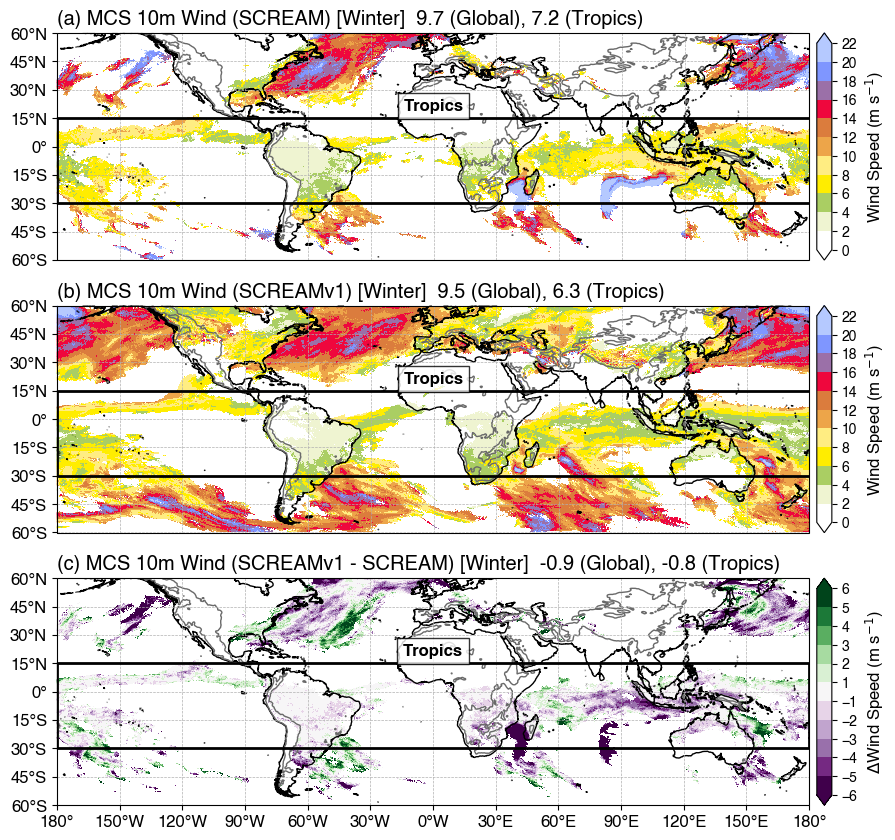

In [30]:
# Filter VAR with min frequency threshold
VAR1 = VAR_mcs_cond_m1.where(mcs_freq_m1 > min_freq_mcs)
VAR2 = VAR_mcs_cond_m2.where(mcs_freq_m2 > min_freq_mcs)
VAR3 = VAR_mcs_cond_diff.where((mcs_freq_m1 > min_freq_mcs) & (mcs_freq_m2 > min_freq_mcs))
dataarray = [[VAR1], [VAR2], [VAR3]]
nrow = len(dataarray)
ncol = len(dataarray[0])
# Global mean
avg_m1 = VAR1.mean().values.item()
avg_m2 = VAR2.mean().values.item()
avg_diff = VAR3.mean().values.item()
# Tropics mean
avg_tropics_m1 = VAR1.sel(lat=slice(lat_bounds[0],lat_bounds[1]), lon=slice(lon_bounds[0],lon_bounds[1])).mean().values.item()
avg_tropics_m2 = VAR2.sel(lat=slice(lat_bounds[0],lat_bounds[1]), lon=slice(lon_bounds[0],lon_bounds[1])).mean().values.item()
avg_diff_tropics = VAR3.sel(lat=slice(lat_bounds[0],lat_bounds[1]), lon=slice(lon_bounds[0],lon_bounds[1])).mean().values.item()

map_extent = [-180., 179.5, -60.1, 60.1]
lonv = np.arange(-180,180.1,30)
latv = np.arange(-60,60.1,15)

figwidth = 10
height_ratio_per_panel = (map_extent[3] - map_extent[2]) / (map_extent[1] - map_extent[0])
figheight = nrow * (figwidth / ncol) * height_ratio_per_panel
figsize = [figwidth,figheight]

# Set up contour levels and colormaps
lev1 = mcs_dict['lev1']
lev2 = mcs_dict['lev2']
# Remove mid-point (0 value)
idx = int((len(lev2)-1)/2)
lev2 = np.delete(lev2, idx)
levels = [[lev1]*ncol, [lev1]*ncol, [lev2]*ncol]
cmap1 = mcs_dict['cmap1']
cmap2 = mcs_dict['cmap2']
cmaps = [[cmap1]*ncol,[cmap1]*ncol,[cmap2]*ncol]
# Specify lat/lon labels
label_lon = [[False],[False],[True],]
label_lat = [[True],[True],[True]]

titles = [
    [f"(a) {mcs_dict['title']} ({name_map['m1']}) [{PHASE}]  {avg_m1:0.1f} (Global), {avg_tropics_m1:0.1f} (Tropics)"],
    [f"(b) {mcs_dict['title']} ({name_map['m2']}) [{PHASE}]  {avg_m2:0.1f} (Global), {avg_tropics_m2:0.1f} (Tropics)"],
    [f"(c) {mcs_dict['title']} ({name_map['m2']} - {name_map['m1']}) [{PHASE}]  {avg_diff:0.1f} (Global), {avg_diff_tropics:0.1f} (Tropics)"],
]
cblabels = [[cb_text],[cb_text],[r'$\Delta$'+cb_text]]
cbticks = levels
figname = f"{figdir}globalmap_scream_{varname}_mcs.png"
oob_colors = None
fontsize = 12
cb_fontsize = 10
print(figname)

fig = plot_maps_mxn(nrow, ncol, dataarray, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                    figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, show_cb2=False,
                    boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
                    map_extent=map_extent, lonv=lonv, latv=latv, label_lon=label_lon, label_lat=label_lat)